# Stackoverflow Classification

### Load Dataset

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [2]:
! kaggle datasets download -d imoore/60k-stack-overflow-questions-with-quality-rate

 43% 9.00M/21.0M [00:01<00:01, 8.75MB/s]
100% 21.0M/21.0M [00:01<00:00, 14.1MB/s]


In [3]:
! unzip 60k-stack-overflow-questions-with-quality-rate.zip

Archive:  60k-stack-overflow-questions-with-quality-rate.zip
  inflating: train.csv               
  inflating: valid.csv               


### Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve

## Data Preprocesing and Exploratory

In [4]:
# Read Data
df = pd.read_csv('train.csv')
df.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [5]:
df.shape

(45000, 6)

Text(0.5, 1.0, 'Data Distribution based on Y')

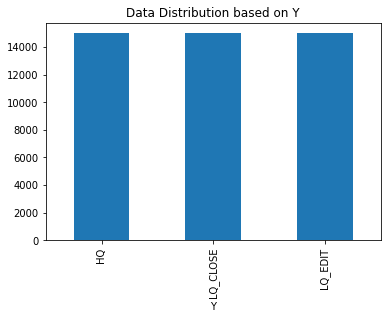

In [6]:
df.groupby('Y')['Id'].count().sort_values().plot(kind='bar')
plt.title('Data Distribution based on Y')

In [7]:
# checking null values
df.isnull().sum()

Id              0
Title           0
Body            0
Tags            0
CreationDate    0
Y               0
dtype: int64

In [8]:
# drop unnecesary data
df = df.drop(['Id', 'Tags', 'CreationDate'], axis=1)

In [9]:
# mapping Y values to numerical
df['Y'] = df['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
df.head()

,Title,Body,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,0
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,2
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,2
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",2
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,2


In [10]:
# join the title and body column
df['text'] = df['Title'] + ' ' + df['Body']
df = df.drop(['Title', 'Body'], axis=1)
df.head()

,Y,text
0,0,Java: Repeat Task Every Random Seconds <p>I'm ...
1,2,Why are Java Optionals immutable? <p>I'd like ...
2,2,Text Overlay Image with Darkened Opacity React...
3,2,Why ternary operator in swift is so picky? <p>...
4,2,hide/show fab with scale animation <p>I'm usin...


In [11]:
# Data cleansing and make the text lowercase
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^(a-zA-Z)\s]','', text)
    return text
df['text'] = df['text'].apply(clean_text)
df.head()

,Y,text
0,0,java repeat task every random seconds pim alre...
1,2,why are java optionals immutable pid like to u...
2,2,text overlay image with darkened opacity react...
3,2,why ternary operator in swift is so picky pthe...
4,2,hideshow fab with scale animation pim using cu...


In [12]:
df.shape

(45000, 2)

In [13]:
# Split Data for target and feature
X = df['text']
y = df['Y']

In [14]:
# Vectorizing data
tf = TfidfVectorizer()
X = tf.fit_transform(X)

In [15]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [16]:
def plot(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show

## Multinomial Naive Bayes

In [17]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_pred = nb.predict(X_test)

In [18]:
print(classification_report(y_test,nb_pred))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      4463
           1       0.94      0.70      0.80      4560
           2       0.73      0.88      0.80      4477

    accuracy                           0.78     13500
   macro avg       0.80      0.78      0.78     13500
weighted avg       0.80      0.78      0.79     13500



Confusion matrix, without normalization
[[3426  187  850]
 [ 770 3210  580]
 [ 490   32 3955]]


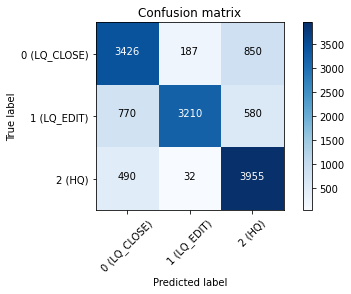

In [19]:
nb_matrix = confusion_matrix(y_test,nb_pred)
plot(nb_matrix, classes=["0 (LQ_CLOSE)","1 (LQ_EDIT)","2 (HQ)"], title='Confusion matrix Naive Bayes')

## Logistic Regression

In [20]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:
print(classification_report(y_test,lr_pred))

              precision    recall  f1-score   support

           0       0.85      0.78      0.82      4463
           1       0.90      0.97      0.94      4560
           2       0.85      0.86      0.85      4477

    accuracy                           0.87     13500
   macro avg       0.87      0.87      0.87     13500
weighted avg       0.87      0.87      0.87     13500



Confusion matrix, without normalization
[[3479  375  609]
 [  54 4435   71]
 [ 537   98 3842]]


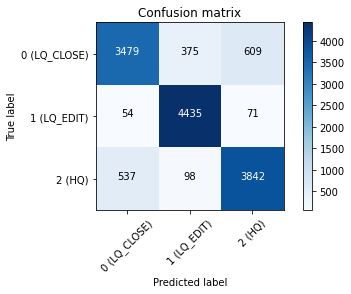

In [22]:
lr_matrix = confusion_matrix(y_test,lr_pred)
plot(lr_matrix, classes=["0 (LQ_CLOSE)","1 (LQ_EDIT)","2 (HQ)"], title='Confusion matrix Logistic Regression')

## Random Forest Classifier

In [27]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

In [28]:
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      4463
           1       0.88      0.96      0.92      4560
           2       0.83      0.76      0.79      4477

    accuracy                           0.83     13500
   macro avg       0.83      0.83      0.83     13500
weighted avg       0.83      0.83      0.83     13500



Confusion matrix, without normalization
[[3413  446  604]
 [  92 4397   71]
 [ 942  154 3381]]


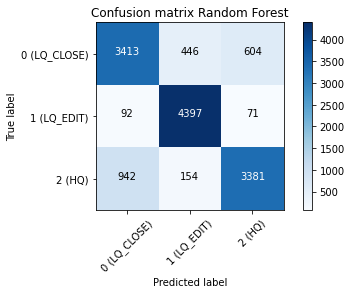

In [29]:
rf_matrix = confusion_matrix(y_test,rf_pred)
plot(rf_matrix, classes=["0 (LQ_CLOSE)","1 (LQ_EDIT)","2 (HQ)"], title='Confusion matrix Random Forest')

## KNN

In [33]:
from sklearn import metrics
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.53422222, 0.50155556, 0.55637037, 0.5522963 , 0.55918519,
       0.56962963, 0.5757037 , 0.57903704, 0.58503704, 0.59214815,
       0.59133333, 0.594     , 0.59814815, 0.60096296, 0.60207407,
       0.60577778, 0.604     , 0.60325926, 0.6057037 ])

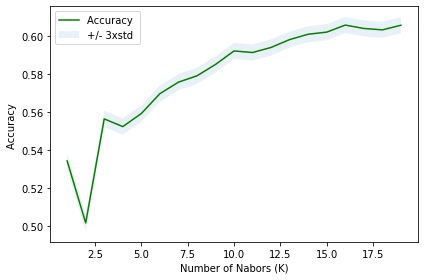

In [34]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [35]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.6057777777777777 with k= 16


In [36]:
n = 16
kn = KNeighborsClassifier(n_neighbors=n)
kn.fit(X_train,y_train)
kn_pred = kn.predict(X_test)

In [37]:
print(classification_report(y_test,kn_pred))

              precision    recall  f1-score   support

           0       0.52      0.61      0.56      4463
           1       0.58      0.62      0.60      4560
           2       0.79      0.59      0.67      4477

    accuracy                           0.61     13500
   macro avg       0.63      0.61      0.61     13500
weighted avg       0.63      0.61      0.61     13500



Confusion matrix, without normalization
[[2722 1369  372]
 [1401 2806  353]
 [1156  671 2650]]


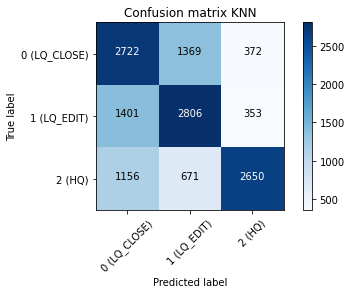

In [38]:
kn_matrix = confusion_matrix(y_test,kn_pred)
plot(kn_matrix, classes=["0 (LQ_CLOSE)","1 (LQ_EDIT)","2 (HQ)"], title='Confusion matrix KNN')

## Decision Tree

In [42]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt_pred = dt.predict(X_test)

In [43]:
print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      4463
           1       0.98      0.98      0.98      4560
           2       0.70      0.69      0.69      4477

    accuracy                           0.79     13500
   macro avg       0.79      0.79      0.79     13500
weighted avg       0.79      0.79      0.79     13500



Confusion matrix, without normalization
[[3099   66 1298]
 [  47 4480   33]
 [1349   41 3087]]


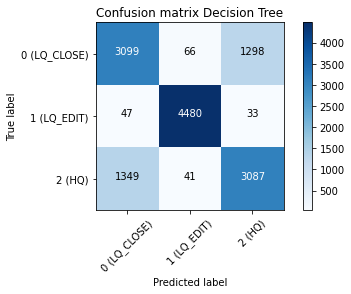

In [44]:
dt_matrix = confusion_matrix(y_test,dt_pred)
plot(dt_matrix, classes=["0 (LQ_CLOSE)","1 (LQ_EDIT)","2 (HQ)"], title='Confusion matrix Decision Tree')

## XGBoost

In [39]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_test)

In [40]:
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75      4463
           1       0.86      1.00      0.92      4560
           2       0.80      0.76      0.78      4477

    accuracy                           0.82     13500
   macro avg       0.82      0.82      0.82     13500
weighted avg       0.82      0.82      0.82     13500



Confusion matrix, without normalization
[[2722 1369  372]
 [1401 2806  353]
 [1156  671 2650]]


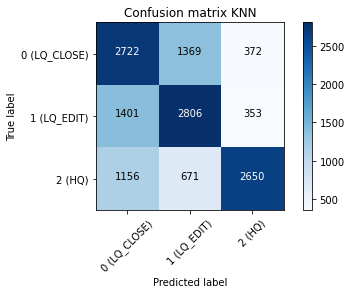

In [41]:
xgb_matrix = confusion_matrix(y_test,kn_pred)
plot(kn_matrix, classes=["0 (LQ_CLOSE)","1 (LQ_EDIT)","2 (HQ)"], title='Confusion matrix XGBoost')

## Kesimpulan

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

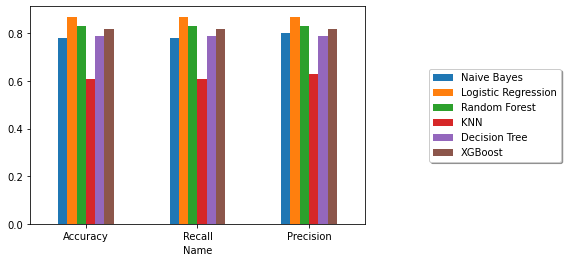

In [105]:
data_all = [['Accuracy',0.78,0.87,0.83,0.61,0.79,0.82],['Recall',0.78,0.87,0.83,0.61,0.79,0.82],['Precision',0.80,0.87,0.83,0.63,0.79,0.82]]
dfk = pd.DataFrame(data_all, columns = ['Name','Naive Bayes','Logistic Regression','Random Forest','KNN','Decision Tree','XGBoost'])

fig, ax = plt.subplots()
dfk.plot.bar(x='Name', ax=ax)
plt.legend(loc='right',bbox_to_anchor=(1.6,0.5),shadow=True,ncol=1)
plt.xticks(rotation=0)